In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pulp as pl

In [37]:
class karmbandit:
    """This is the k arm bandit problem

    Attributes:
        d: number of arms
        distribution (str): distribution of rewards
        params (array): parameters of the distribution, the line i contain the parameters of the distribution of the arm i
        best_arm (int): index of the best arm
    """

    def __init__(self, d, distribution, params):
        """Init the k arm bandit problem

        Args:
            d (int): number of arms
            distribution (str): distribution of rewards
            params (array): parameters of the distribution, the line i contain the parameters of the distribution of the arm i
        """

        self.d = d
        self.distribution = distribution
        self.params = params
        if distribution == 'bernoulli':
            self.mus = params
            self.sigmas = 1/2*np.ones(d)
        if distribution == 'gaussian':
            self.mus = params[:,0]
            self.sigmas = params[:,1]
        
        self.best_arm = np.argmax(self.mus)
        self.mustar = self.mus[self.best_arm]

    def pull(self):
        """Pull the arms
        
        Returns:
            reward (float): reward of the arms
        """

        if self.distribution == 'bernoulli':
            return np.random.binomial(1,self.mus)
        if self.distribution == 'gaussian':
            return np.random.normal(self.mus, self.sigmas)

class karmpolicy:
    """This is the k arm bandit policy

    Attributes:
        d: number of armsArgs:
            index (int): index of the arm to pull
        self.muhat (array): empiric mean of the arms
        t (int): time step
        w (array): number of time an arm is played
        regrets (list) : regret at each time step
        policy (str): policy to use
        params (array): parameters of the policy
    """

    def __init__(self, karmbandit, policy, algoparams = None, prior = "uniform"):
        """Init the k arm bandit policy

        Args:
            d (int): number of arms
            policy (str): policy to use
            algoparams (array): parameters of the policy, c for ucb, epsilon for epsilon-greedy, param of the prior for thompson sampling
            prior (str): by default it is the uniform prior
        """
        # get the parameters of the k arm bandit problem
        self.karmbandit = karmbandit
        self.d = karmbandit.d
        self.bestarm = karmbandit.best_arm
        self.mus = karmbandit.mus
        self.sigmas = karmbandit.sigmas
        self.distribution = karmbandit.distribution
        self.mustar = karmbandit.mustar

        # store in the class the policy and the initial parameters
        self.policy = policy
        self.algoparams = algoparams

        # initialise the paramater of the algorithm
        self.regrets = []
        self.muhats = np.zeros(self.d)
        self.prior = prior
        # small hack to avoid division by 0 before the arm is played for the first time
        self.t = 1
        self.w = np.ones(self.d) * 10**(-8)

        if policy == 'epsilon-greedy':
            self.epsilon = self.algoparams[0]
        if policy == 'explore-commit':
            self.explore = self.algoparams[0]
            self.currentexplore = 1
        if policy == 'ucb':
            self.c = self.algoparams[0]
        if policy == 'thompson-sampling':
            if self.distribution == 'bernoulli':
                if self.prior == "beta":
                    self.alphas = self.algoparams[:0].copy()
                    self.betas = self.algoparams[:1].copy()
                if self.prior == "uniform":
                    self.alphas = np.ones(self.d)
                    self.betas = np.ones(self.d)
                if self.prior == "gaussian":
                    # In the case of a gaussian prior for bernoulli distribution we assume that the prior is uniform on R
                    # And that the bernoulli are gaussian with variance 1/4 
                    self.mus = np.zeros(self.d)
                    self.sigmapost = 10**-8 * np.ones(self.d)
            if self.distribution == 'gaussian':
                if prior == "gaussian":
                    self.mushats = self.algoparams[:0].copy()
                    self.sigmapost = self.algoparams[:1].copy()
                if self.prior == "uniform":
                    self.mushats = np.zeros(self.d)
                    self.sigmapost = 10**8 * np.ones(self.d)
        if policy == "klucb":
            pass
    
    def reset(self):
        # initialise the paramater of the algorithm
        self.regrets = []
        self.muhats = np.zeros(self.d)
        # small hack to avoid division by 0 before the arm is played for the first time
        self.t = 1
        self.w = np.ones(self.d) * 10**(-8)

        if self.policy == 'epsilon-greedy':
            self.epsilon = self.algoparams[0]
        if self.policy == 'explore-commit':
            self.explore = self.algoparams[0]
            self.currentexplore = 1
        if self.policy == 'ucb':
            self.c = self.algoparams[0]
        if self.policy == 'thompson-sampling':
            if self.distribution == 'bernoulli':
                if self.prior == "beta":
                    self.alphas = self.algoparams[:0].copy()
                    self.betas = self.algoparams[:1].copy()
                if self.prior == "uniform":
                    self.alphas = np.ones(self.d)
                    self.betas = np.ones(self.d)
                if self.prior == "gaussian":
                    # In the case of a gaussian prior for bernoulli distribution we assume that the prior is uniform on R
                    # And that the bernoulli are gaussian with variance 1/4 
                    self.mus = np.zeros(self.d)
                    self.sigmapost = 10**-8 * np.ones(self.d)
            if self.distribution == 'gaussian':
                if self.prior == "gaussian":
                    self.mushats = self.algoparams[:0].copy()
                    self.sigmapost = self.algoparams[:1].copy()
                if self.prior == "uniform":
                    self.mushats = np.zeros(self.d)
                    self.sigmapost = 10**8 * np.ones(self.d)
        if self.policy == "klucb":
            pass
    


    def select(self):
        """Select the arm to pull according to the algorithm policy
        
        Returns:
            index (int): index of the arm to pull
        """
        if self.policy == 'ucb':
            index = np.argmax(self.muhats + self.c * np.sqrt(2*np.log(self.t) / (self.w)))
        if self.policy == 'epsilon-greedy':
            if np.random.rand() < self.epsilon:
                index = np.random.randint(self.d)
            else:
                index = np.argmax(self.muhats)

        
        if self.policy == 'explore-commit':
            # keep exploring until every arm are explored self.explore times
            if np.any(self.w < self.explore):
                index = np.argmax(self.w < self.explore)
            else:
                index = np.argmax(self.muhats)

        if self.policy == 'ucb':
            index = np.argmax(self.muhats + self.c * np.sqrt(2*np.log(self.t) / (self.w)))


        if self.policy == 'thompson-sampling':
            if self.prior == 'bernoulli' or self.prior == 'uniform':
                index = np.argmax(np.random.beta(self.alphas, self.betas))
            if self.prior == 'gaussian':
                index = np.argmax(np.random.normal(self.muhats, self.sigmapost))

        if self.policy == "klucb":
            pass
        return index

    def update(self, index, reward):
        """Update the policy
        
        Args:
            index (int): index of the arm to pull
            reward (float): reward of the arm
        """
        self.t += 1

        
        if self.w[index] < 0.5:
            # correct the hack to avoid division by 0
            self.w[index] = 1
        else:
            self.w[index] += 1
        if self.policy == 'epsilon-greedy':
            self.muhats[index] = (self.muhats[index] * (self.w[index] - 1) + reward) / self.w[index]
        if self.policy == 'explore-commit':
            self.muhats[index] = (self.muhats[index] * (self.w[index] - 1) + reward) / self.w[index]

        if self.policy == "ucb":
            self.muhats[index] = (self.muhats[index] * (self.w[index] - 1) + reward) / self.w[index]

        if self.policy == 'thompson-sampling':
            if self.distribution == 'bernoulli':
                if self.prior == 'beta' or self.prior == 'uniform':
                    self.alphas[index] += reward
                    self.betas[index] += 1 - reward
                if self.prior == 'gaussian':
                    self.muhats[index] = (self.muhats[index] * (self.w[index] - 1) + reward) / self.w[index] 
                    # I already verified the above formula
                    if self.sigmapost[index] == 10**8:
                        self.sigmapost[index] = np.sqrt(1/4)
                    else:
                        self.sigmapost[index] = np.sqrt((1/self.sigmapost[index]**2 + 1/4)**-1)
                    

            if self.distribution == 'gaussian':
                if self.prior == 'uniform':
                    self.muhats[index] = (self.muhats[index] * (self.w[index] - 1) + reward) / self.w[index]
                    if self.sigmapost[index] == 10**8:
                        self.sigmapost[index] = self.sigmas[index]
                    else:
                        self.sigmapost[index] = np.sqrt((1/self.sigmapost[index]**2 + 1/self.sigmas[index]**2)**-1)
                if self.prior == 'gaussian':
                    self.sigmapost[index] = np.sqrt((1/self.sigmapost[index] + 1/self.sigmas[index])**-1)
                    self.muhats = self.sigmapost[index]**2 * (self.muhats[index] / self.sigmapost[index]**2 + reward / self.sigmas[index]**2)
                    # The above formula is verified


        

        self.regrets.append(self.mustar - self.mus[index])

        
            






In [43]:
# test the code

d=10
T = 10000
n = 20
# create a d arm bandit problem
problem = karmbandit(d, distribution='bernoulli', params=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# initialise the algorithms

TS = karmpolicy(problem, "thompson-sampling", prior = "uniform")
UCB = karmpolicy(problem, "ucb", algoparams=[1])
egreedy = karmpolicy(problem, "epsilon-greedy", algoparams=[d/(0.1)**2/T])
excommit = karmpolicy(problem, "explore-commit", algoparams=[np.log(T*(0.1)**2)/(0.1)**2])

TSregret = np.zeros((n,T))
UCBregret = np.zeros((n,T))
egreedyregret = np.zeros((n,T))
excommitregret = np.zeros((n,T))

for k in range(n):
    for i in range(T):

        rewards = problem.pull()
        index = TS.select()
        TS.update(index, rewards[index])

        index = UCB.select()
        UCB.update(index, rewards[index])
        
        index = egreedy.select()
        egreedy.update(index, rewards[index])

        index = excommit.select()
        excommit.update(index, rewards[index])

    TSregret[k] = TS.regrets.copy()
    UCBregret[k] = UCB.regrets.copy() 
    egreedyregret[k] = egreedy.regrets.copy()
    excommitregret[k] = excommit.regrets.copy()

    print("TS regret: ", np.sum(TS.regrets))
    print("UCB regret: ", np.sum(UCB.regrets))
    print("egreedy regret: ", np.sum(egreedy.regrets))
    print("excommit regret: ", np.sum(excommit.regrets))
    TS.reset()
    UCB.reset()
    egreedy.reset()
    excommit.reset()    


TS regret:  14.5
UCB regret:  376.8
egreedy regret:  441.6
excommit regret:  2074.5
TS regret:  12.3
UCB regret:  369.6
egreedy regret:  471.7
excommit regret:  2074.5
TS regret:  8.8
UCB regret:  333.69999999999993
egreedy regret:  489.8
excommit regret:  2074.5
TS regret:  9.4
UCB regret:  376.3
egreedy regret:  475.40000000000003
excommit regret:  2074.5
TS regret:  11.899999999999999
UCB regret:  346.59999999999997
egreedy regret:  472.2
excommit regret:  2074.5
TS regret:  15.799999999999997
UCB regret:  372.3
egreedy regret:  444.5
excommit regret:  2074.5
TS regret:  14.0
UCB regret:  359.29999999999995
egreedy regret:  500.4
excommit regret:  2074.5
TS regret:  10.399999999999999
UCB regret:  300.0
egreedy regret:  545.4
excommit regret:  2074.5
TS regret:  10.1
UCB regret:  352.6
egreedy regret:  476.6
excommit regret:  2074.5
TS regret:  11.8
UCB regret:  334.29999999999995
egreedy regret:  516.9
excommit regret:  2074.5
TS regret:  8.100000000000001
UCB regret:  343.8
egreed

In [13]:
# plot the results

In [69]:
def plot_regret(regrets , label = None):
    fig = plt.figure(figsize=(19, 14))
    plt.plot(np.arange(T),np.mean(np.cumsum(regrets, axis = 1), axis=0), label=label)
    plt.xlabel("t", fontsize=20)
    plt.xticks(fontsize=20)
    plt.ylabel("Cumulative Regret", fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(loc='lower right', fontsize=20)

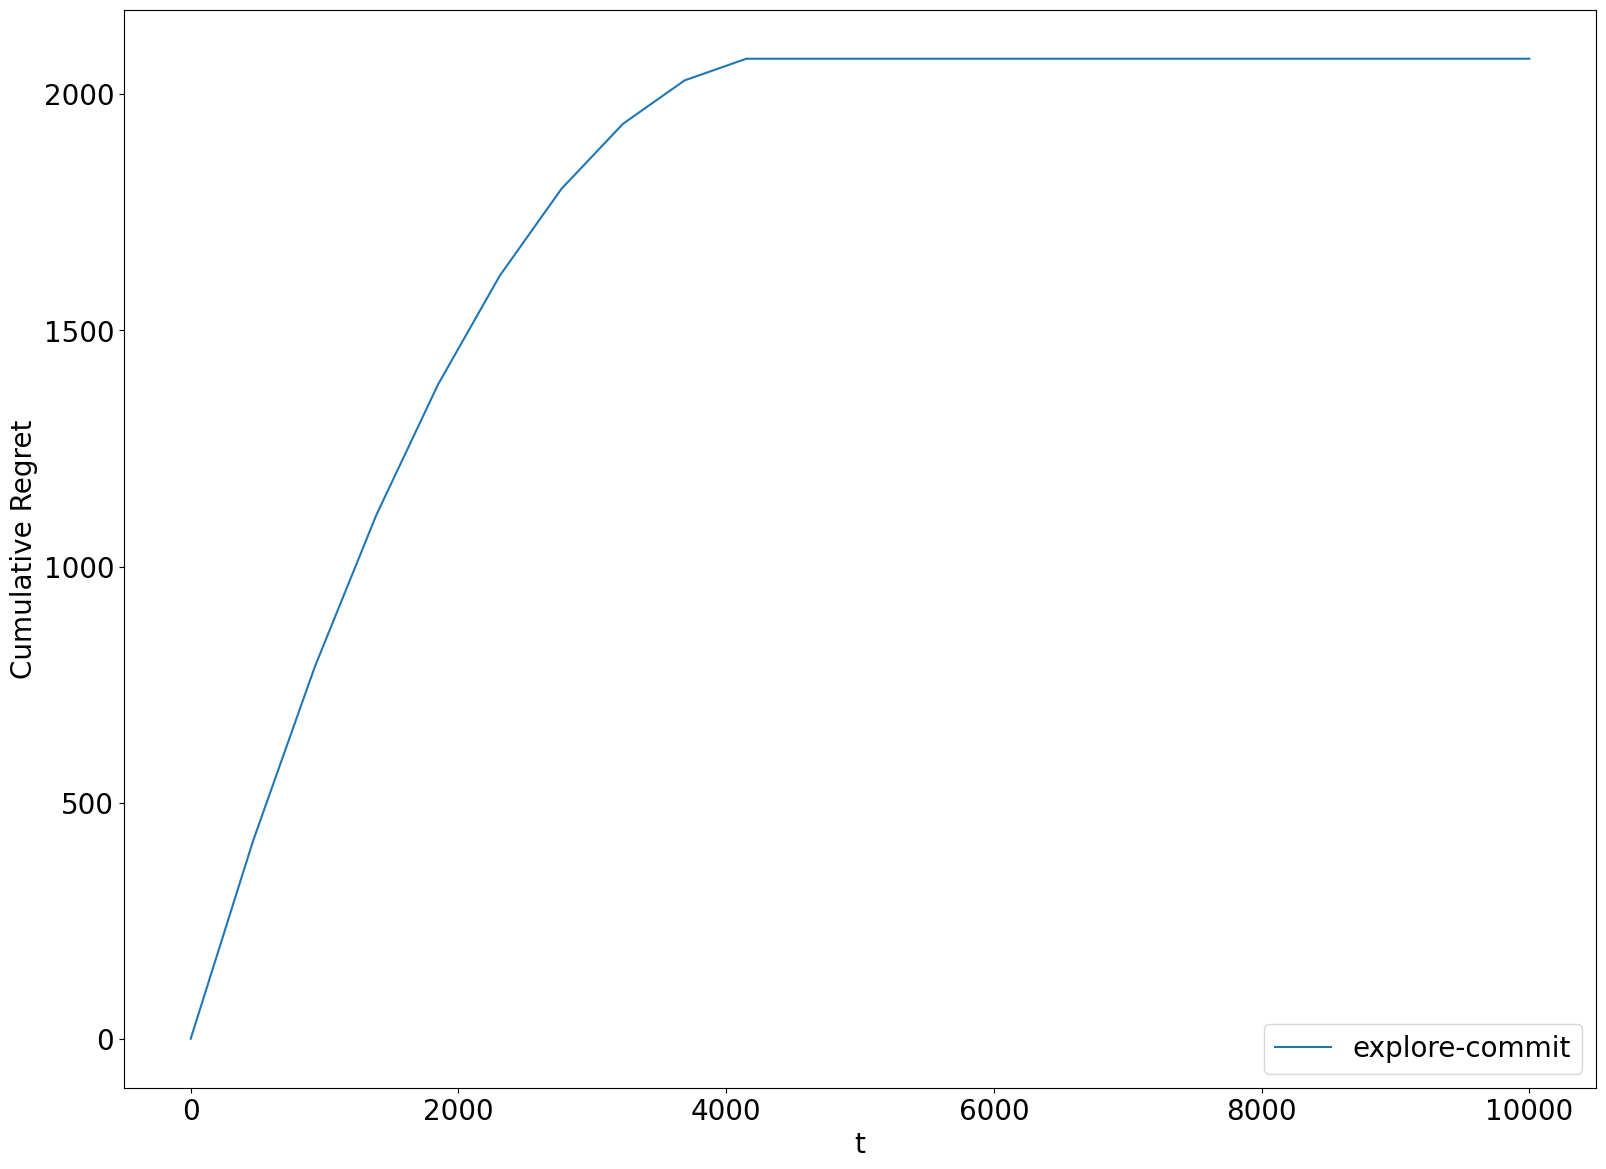

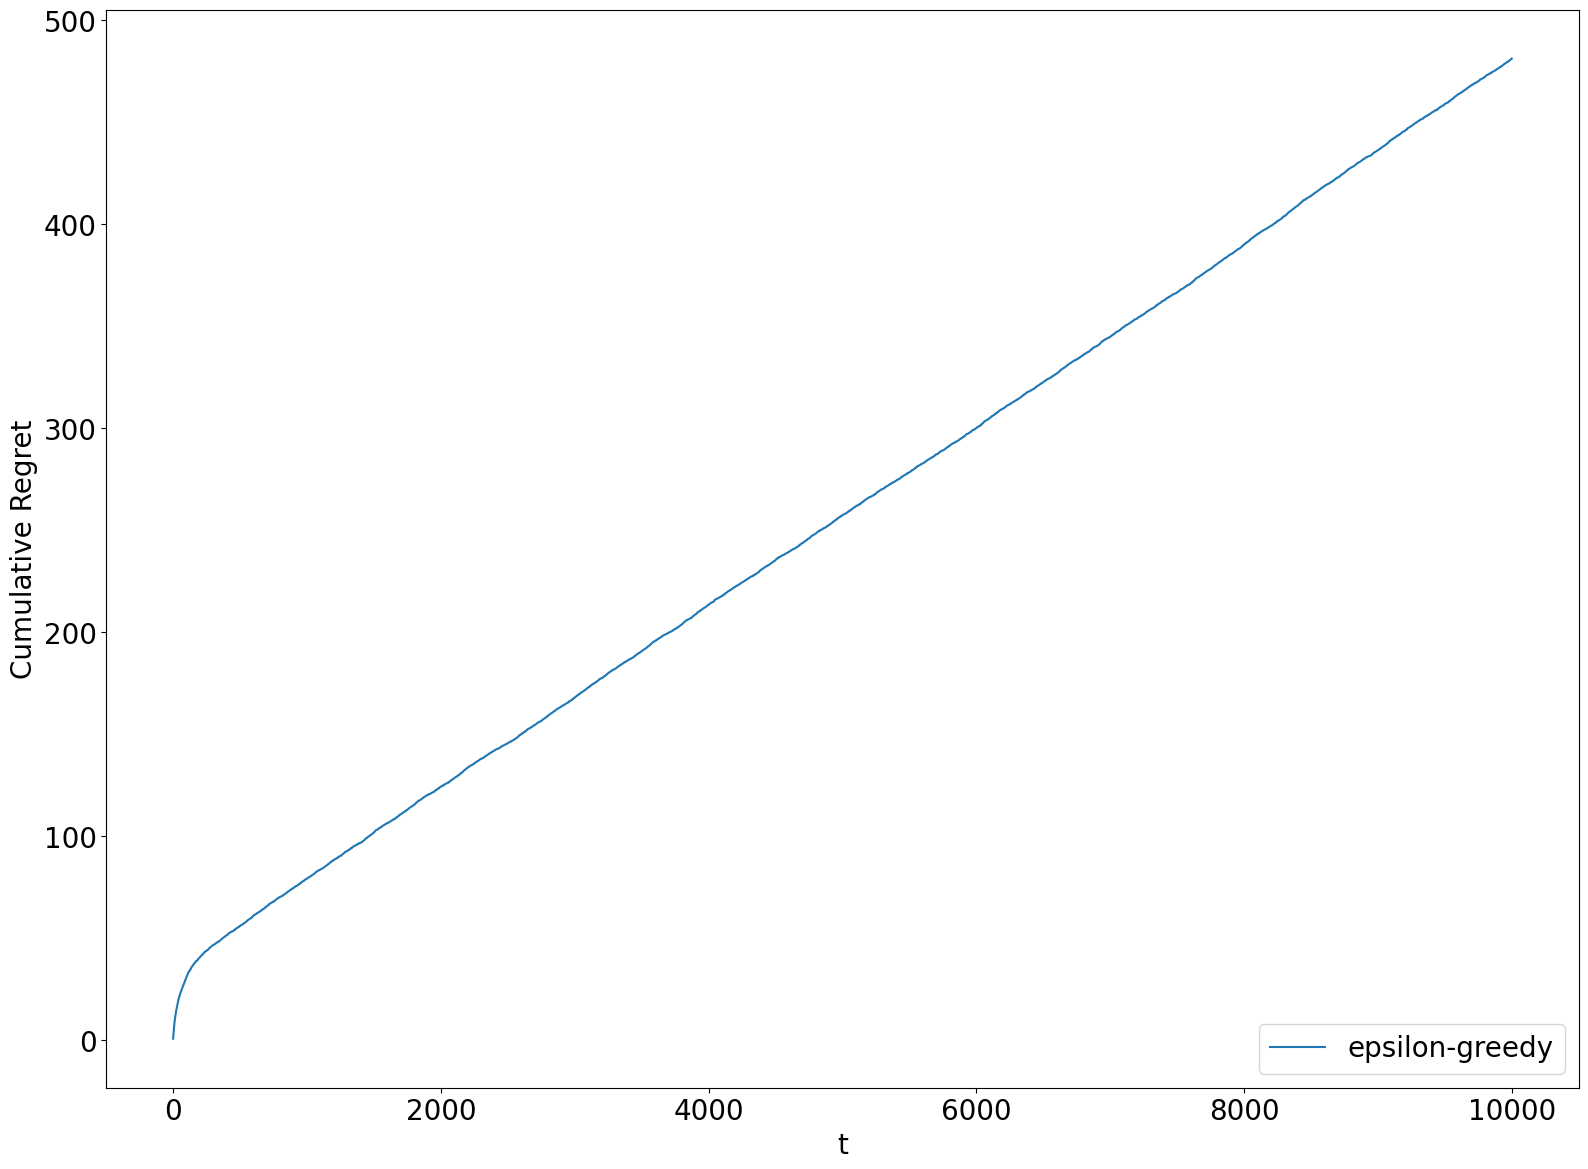

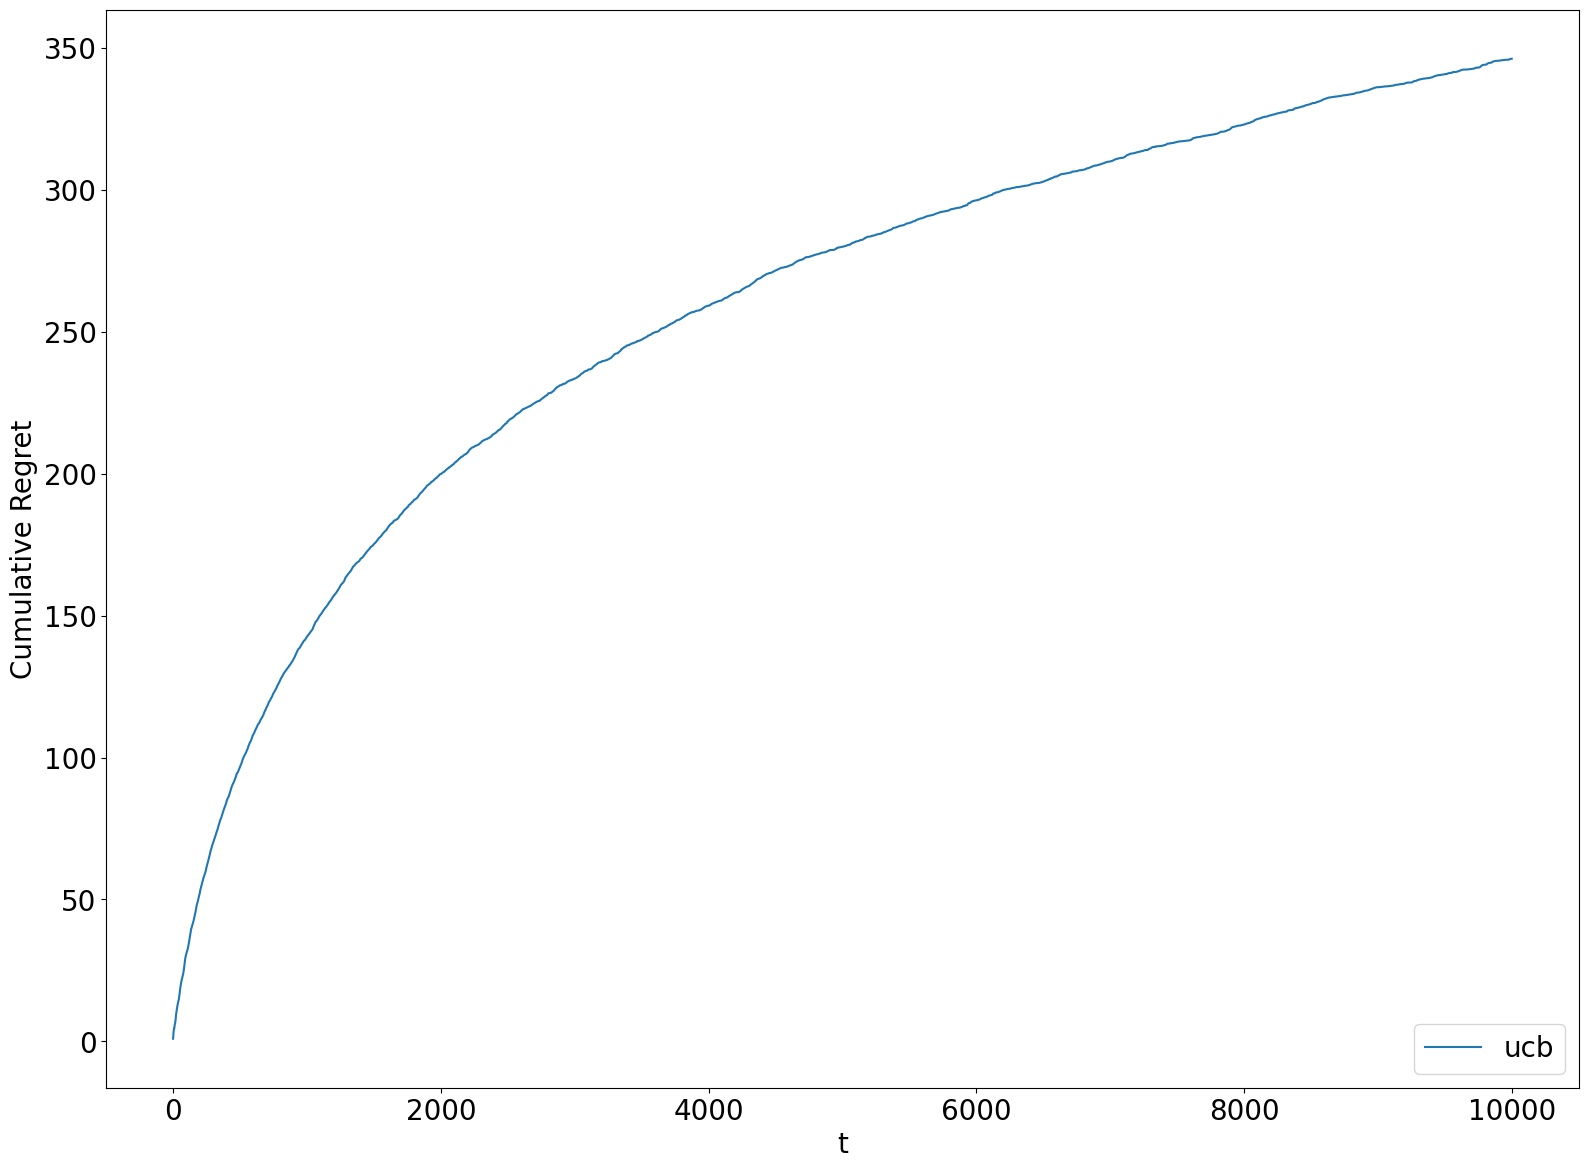

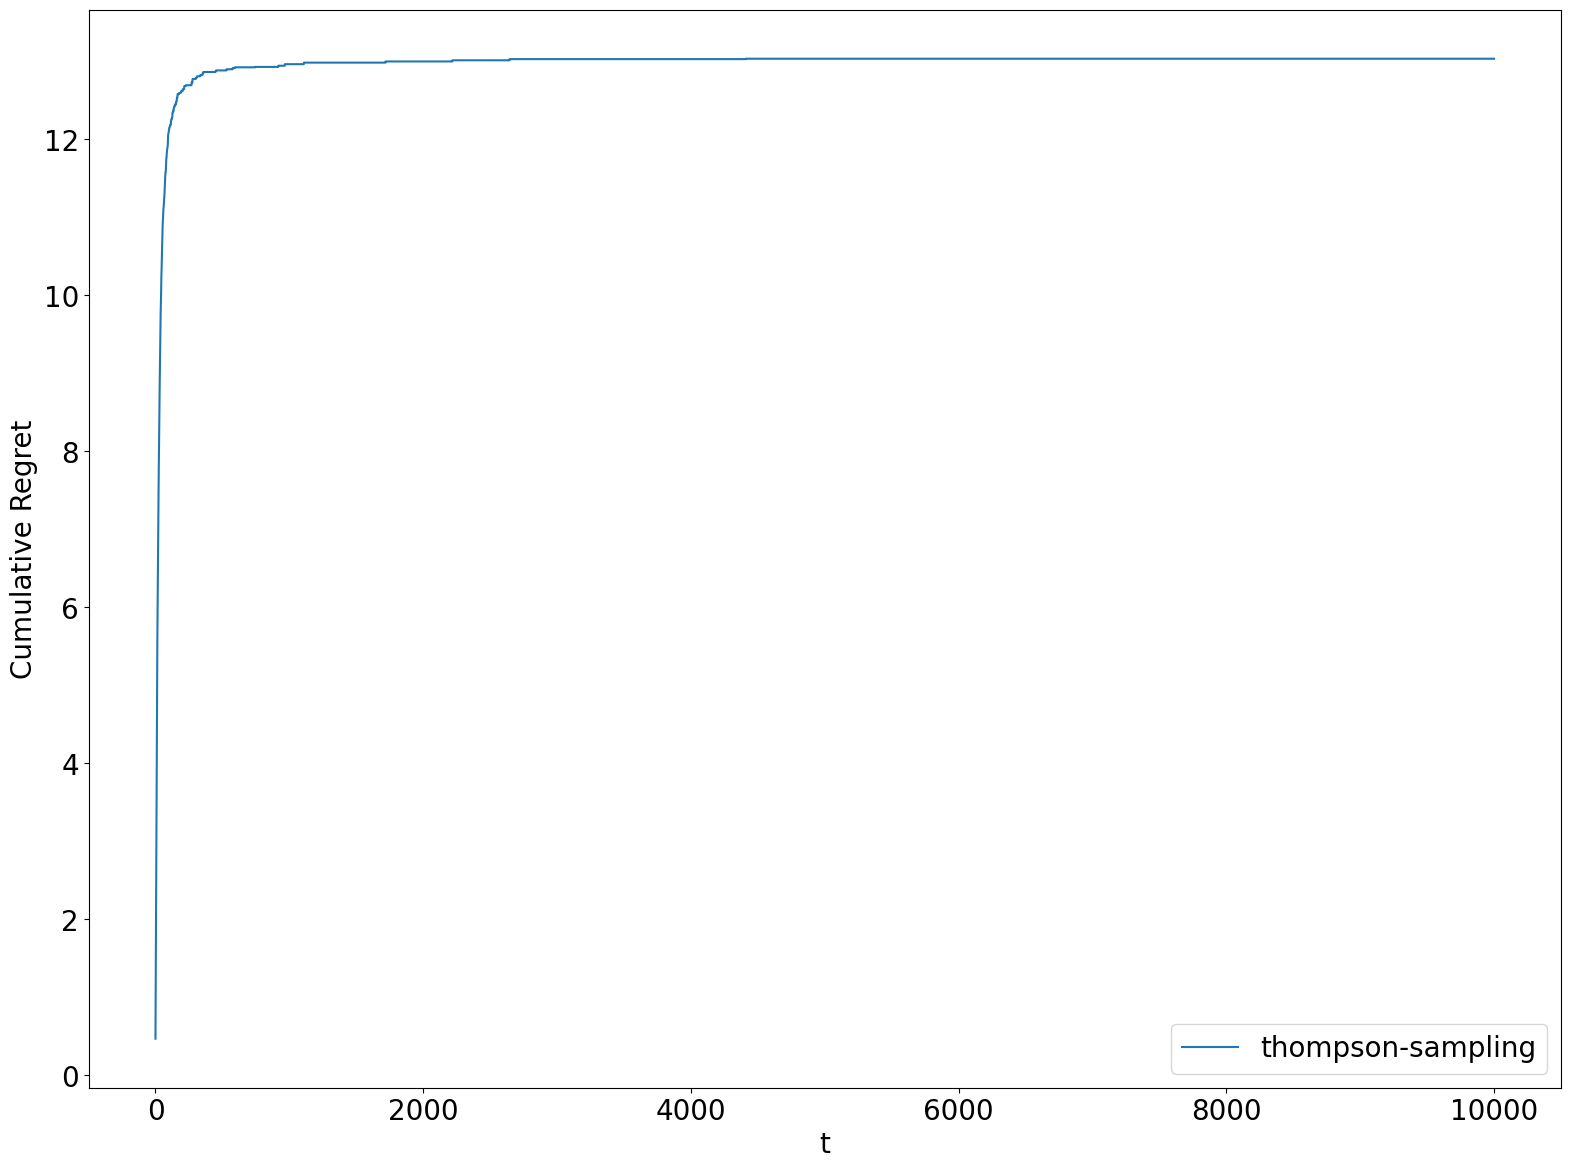

In [70]:
plot_regret(excommitregret, label = "explore-commit")
plot_regret(egreedyregret,  label = "epsilon-greedy")
plot_regret(UCBregret, label = "ucb")
plot_regret(TSregret, label = "thompson-sampling")